# French Salary Prediction

## 1. Importing dataset and data preprocessing
<a id="importing_dataset_and_data_preprocessing"></a>

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy.optimize import curve_fit
import seaborn as sns

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [2]:
geography = pd.read_csv("../00_Datasets/French_firms/name_geographic_information.csv")
industry = pd.read_csv("../00_Datasets/French_firms/base_etablissement_par_tranche_effectif.csv")
salary = pd.read_csv("../00_Datasets/French_firms/net_salary_per_town_categories.csv")
departments_map = gpd.read_file('../00_Datasets/French_firms/departements.geojson')

In [3]:
geography.drop(['EU_circo', 'code_région', 'éloignement', 'préfecture', 'numéro_circonscription', 'codes_postaux'], axis=1, inplace=True)

In [4]:
geography.rename(columns={'nom_région': 'region_name',
                          'chef.lieu_région': 'region_capital',
                          'nom_commune': 'common_name',
                          'numéro_département' : 'department_number',
                          'nom_département' : 'department_name',
                          'codes_postaux': 'postcodes'}, inplace=True)

In [5]:
# 1
geography["longitude"] = geography["longitude"].apply(lambda x: str(x).replace(',','.'))
# 2
mask = geography["longitude"] == '-'
geography.drop(geography[mask].index, inplace=True)
# 3
geography.dropna(subset = ["longitude", "latitude"], inplace=True)
# 4
geography["longitude"] = geography["longitude"].astype(float)

In [6]:
geography.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33847 entries, 0 to 36707
Data columns (total 8 columns):
region_name          33847 non-null object
region_capital       33847 non-null object
department_number    33847 non-null object
department_name      33847 non-null object
common_name          33847 non-null object
code_insee           33847 non-null int64
latitude             33847 non-null float64
longitude            33847 non-null float64
dtypes: float64(2), int64(1), object(5)
memory usage: 2.3+ MB


In [7]:
salary = salary[salary["CODGEO"].apply(lambda x: str(x).isdigit())]
salary["CODGEO"] = salary["CODGEO"].astype(int)

In [8]:
salary_geography = salary.merge(geography, how="left", left_on='CODGEO', right_on="code_insee")

In [9]:
salary_geography.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5246 entries, 0 to 5245
Data columns (total 34 columns):
CODGEO               5246 non-null int32
LIBGEO               5246 non-null object
SNHM14               5246 non-null float64
SNHMC14              5246 non-null float64
SNHMP14              5246 non-null float64
SNHME14              5246 non-null float64
SNHMO14              5246 non-null float64
SNHMF14              5246 non-null float64
SNHMFC14             5246 non-null float64
SNHMFP14             5246 non-null float64
SNHMFE14             5246 non-null float64
SNHMFO14             5246 non-null float64
SNHMH14              5246 non-null float64
SNHMHC14             5246 non-null float64
SNHMHP14             5246 non-null float64
SNHMHE14             5246 non-null float64
SNHMHO14             5246 non-null float64
SNHM1814             5246 non-null float64
SNHM2614             5246 non-null float64
SNHM5014             5246 non-null float64
SNHMF1814            5246 non-null f

In [10]:
salary_geography.dropna(subset = ["longitude", "latitude"], inplace=True)

In [11]:
salary_geography.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4828 entries, 0 to 5161
Data columns (total 34 columns):
CODGEO               4828 non-null int32
LIBGEO               4828 non-null object
SNHM14               4828 non-null float64
SNHMC14              4828 non-null float64
SNHMP14              4828 non-null float64
SNHME14              4828 non-null float64
SNHMO14              4828 non-null float64
SNHMF14              4828 non-null float64
SNHMFC14             4828 non-null float64
SNHMFP14             4828 non-null float64
SNHMFE14             4828 non-null float64
SNHMFO14             4828 non-null float64
SNHMH14              4828 non-null float64
SNHMHC14             4828 non-null float64
SNHMHP14             4828 non-null float64
SNHMHE14             4828 non-null float64
SNHMHO14             4828 non-null float64
SNHM1814             4828 non-null float64
SNHM2614             4828 non-null float64
SNHM5014             4828 non-null float64
SNHMF1814            4828 non-null f

In [12]:
mean_salaries_by_dep = salary_geography.groupby("department_number").mean()

In [13]:
departments_map = departments_map.merge(mean_salaries_by_dep, how="left", left_on="code", right_index=True)

In [14]:
departments_map.columns

Index(['code', 'nom', 'geometry', 'CODGEO', 'SNHM14', 'SNHMC14', 'SNHMP14',
       'SNHME14', 'SNHMO14', 'SNHMF14', 'SNHMFC14', 'SNHMFP14', 'SNHMFE14',
       'SNHMFO14', 'SNHMH14', 'SNHMHC14', 'SNHMHP14', 'SNHMHE14', 'SNHMHO14',
       'SNHM1814', 'SNHM2614', 'SNHM5014', 'SNHMF1814', 'SNHMF2614',
       'SNHMF5014', 'SNHMH1814', 'SNHMH2614', 'SNHMH5014', 'code_insee',
       'latitude', 'longitude'],
      dtype='object')

C:\Users\AFGHAN92\Anaconda3\lib\site-packages\matplotlib\colors.py:496: RuntimeWarning:

invalid value encountered in less



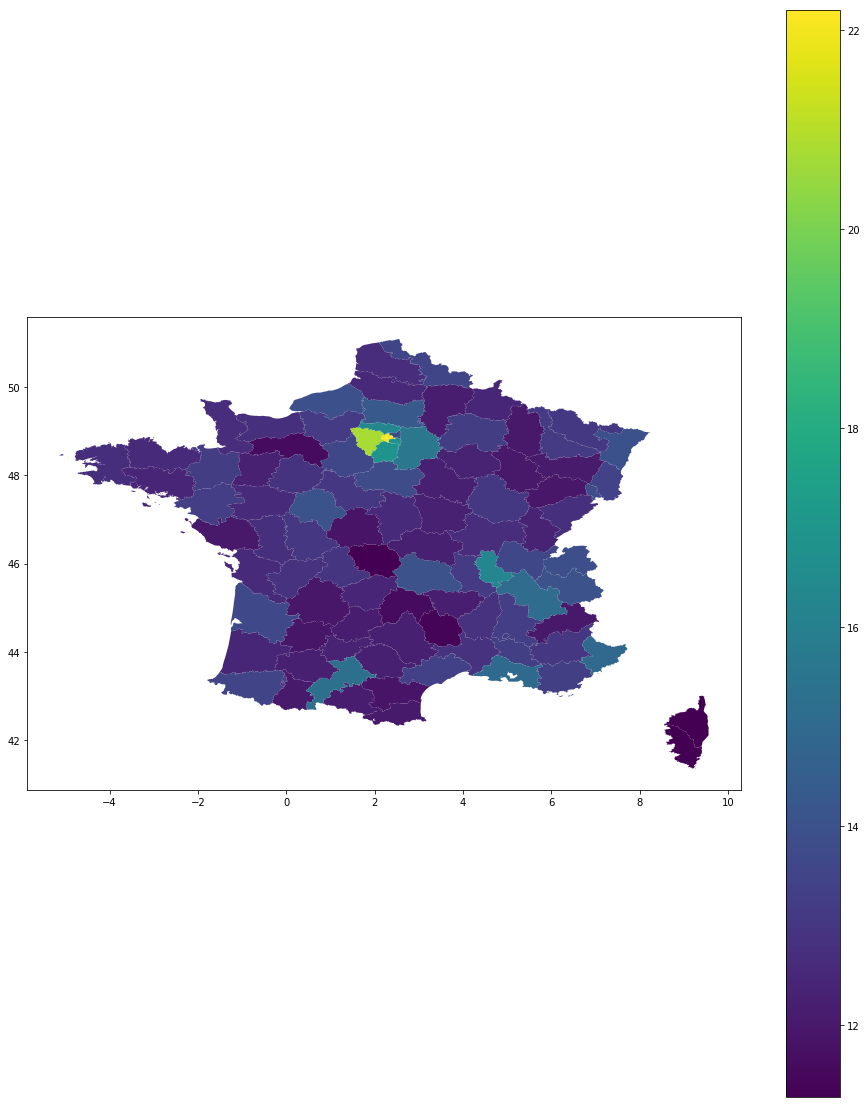

In [26]:
departments_map.plot(figsize=(16, 20), column="SNHM14", legend=True)